# Заработная плата в России

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return np.exp(y)
   else:
      return np.exp(np.log(lmbda*y+1)/lmbda)

Populating the interactive namespace from numpy and matplotlib


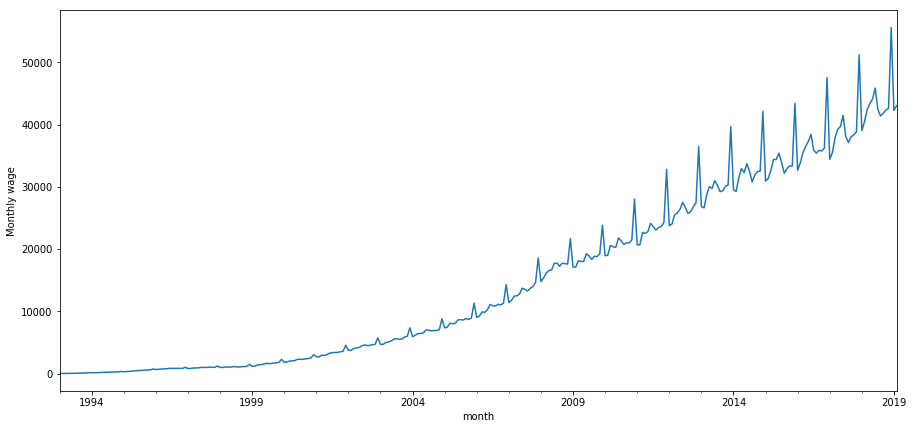

In [2]:
df = pd.read_csv('wage.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize=(15,7))
df.wage.plot()
plt.ylabel('Monthly wage')
plt.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.998265


<Figure size 1080x720 with 0 Axes>

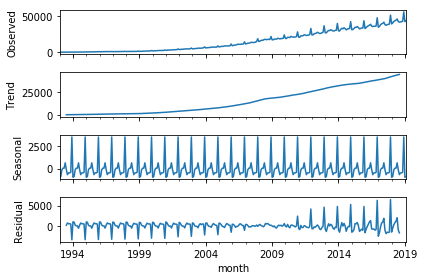

In [3]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage)[1])

## Стабилизация дисперсии

Видим, что со временем дисперсия увеличивается. Поэтому сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.283732
Критерий Дики-Фуллера: p=0.711373


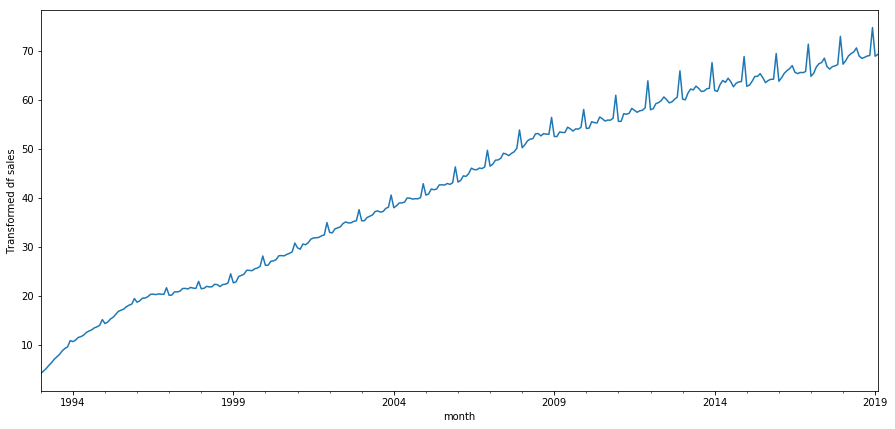

In [4]:
df['wage_box'], lmbda = stats.boxcox(df.wage)
plt.figure(figsize=(15,7))
df.wage_box.plot()
plt.ylabel(u'Transformed df sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box)[1])

## Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. В частности визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.145727


<Figure size 1080x720 with 0 Axes>

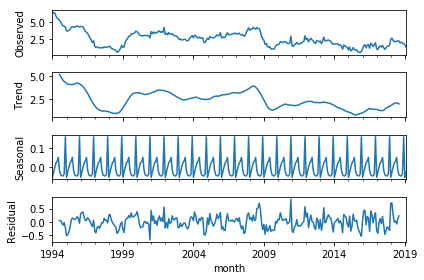

In [5]:
df['wage_box_diff'] = df.wage_box - df.wage_box.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

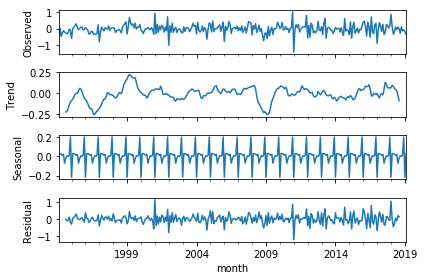

In [6]:
df['wage_box_diff2'] = df.wage_box_diff - df.wage_box_diff.shift(1)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box_diff2[13:])[1])

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

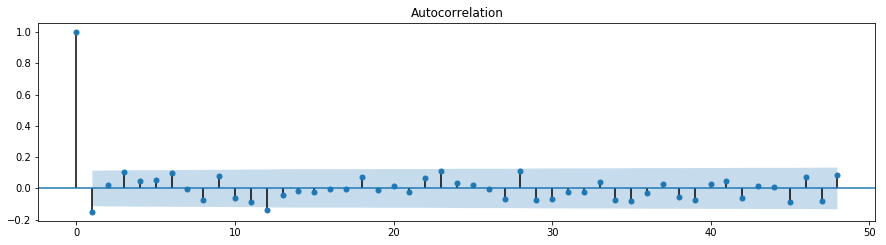

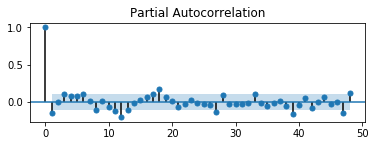

In [7]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: 
Номер последнего сезонного лага, при котором автокорреляция значима - 12. Значит примем
Q=1.
Номер последнего НЕсезонного лага, при котором автокорреляция значима - 1. Значит примем
q=1.
Номер последнего сезонного лага, при котором ЧАСТИЧНАЯ автокорреляция значима - 48. Значит примем
P=4.
Номер последнего НЕсезонного лага (рассматриваем значения меньше 12, так как сезонность уже включает всё большее), при котором корреляция значима - 1. Значит примем
p=1.

In [8]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

40

In [10]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
19  (0, 1, 4, 1)  107.647570
29  (1, 0, 4, 1)  107.695968
39  (1, 1, 4, 1)  109.556493
9   (0, 0, 4, 1)  112.222364
22  (1, 0, 1, 0)  116.669484


Лучшая модель:

In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  314
Model:             SARIMAX(0, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -46.824
Date:                            Wed, 03 Apr 2019   AIC                            107.648
Time:                                    19:24:58   BIC                            133.597
Sample:                                01-01-1993   HQIC                           118.032
                                     - 02-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1487      0.048     -3.129      0.002      -0.242      -0.056
ar.S.L12       0.7183      0.088   

Её остатки:

Критерий Стьюдента: p=0.887287
Критерий Дики-Фуллера: p=0.000029


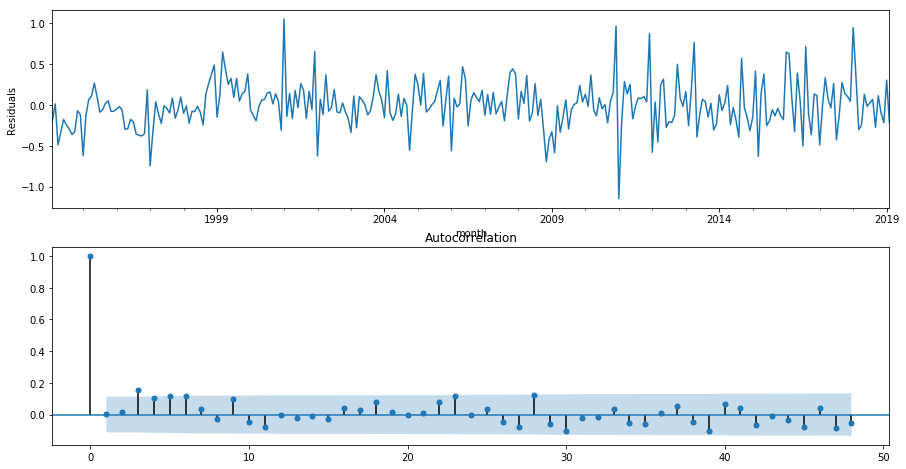

In [13]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

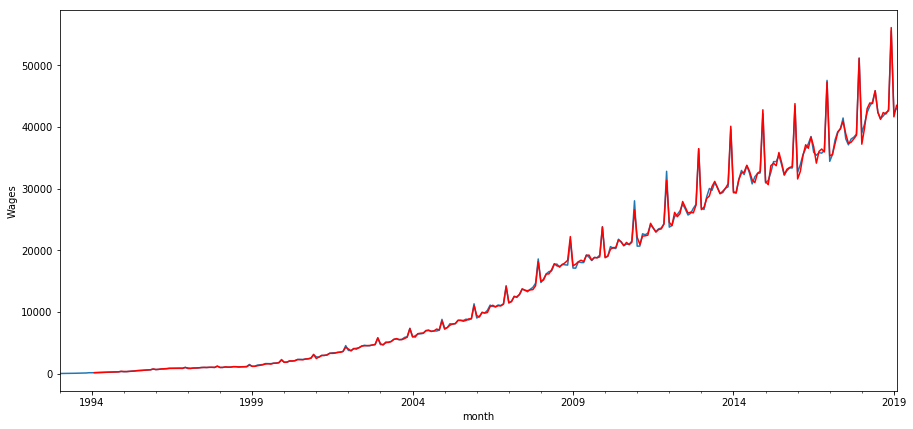

In [14]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
df.wage.plot()
df.model[13:].plot(color='r')
plt.ylabel('Wages')
plt.show()

## Прогноз

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


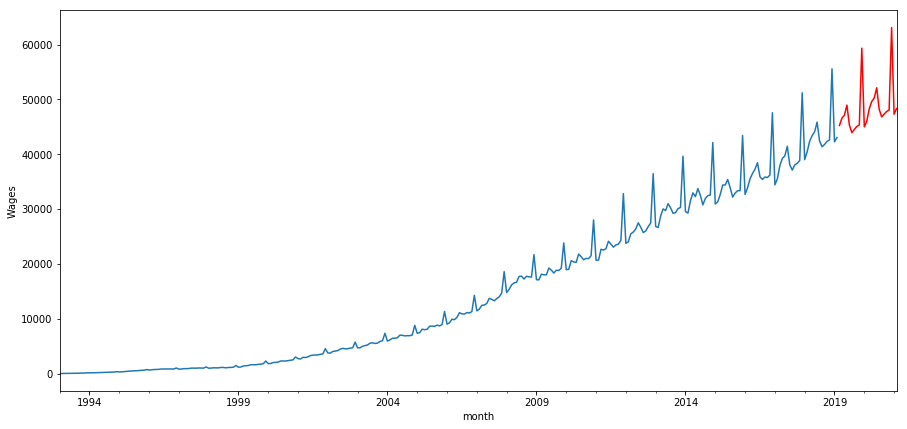

In [15]:
forecast = invboxcox(best_model.forecast(steps=24), lmbda)
plt.figure(figsize=(15,7))
df.wage.plot()
forecast.plot(color='r')
plt.ylabel('Wages')
plt.show()